In [1]:
from src.depth import DepthModel
from src.warp import anim_frame_warp_3d, AnimArgs
import torch
import cv2
from matplotlib import pyplot as plt

e:\Projects\deforumed-walk\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = DepthModel(torch.device("cuda"), "../models/dpt_large_384.pt", False)

In [6]:
img = cv2.imread("../data/girl2.png")
depth = model.predict(img)
model.save_depth("../data/depth.png", depth)

  depth min:1.1987717151641846 max:2.500950574874878


In [11]:
CLIP_FPS = 12
filepath = "../data/MiDaS_test.mp4"
codec = cv2.VideoWriter_fourcc(*"mp4v")
video = cv2.VideoWriter(filepath, codec, CLIP_FPS, (512,512))

# t x
for i in range(0, 30, 2):
    anim_args = AnimArgs(
        near_plane=200,
        far_plane=10_000,
        fov=40,
        padding_mode="zeros",
        sampling_mode="bicubic",
        translation_x_series=[i],
        translation_y_series=[0],
        translation_z_series=[0],
        rotation_3d_x_series=[0],
        rotation_3d_y_series=[0],
        rotation_3d_z_series=[0],
    )
    result=  anim_frame_warp_3d(torch.device("cuda"), img, depth, anim_args,0)
    video.write(result)
for i in range(30, -30, -2):
    anim_args = AnimArgs(
        near_plane=200,
        far_plane=10_000,
        fov=40,
        padding_mode="zeros",
        sampling_mode="bicubic",
        translation_x_series=[i],
        translation_y_series=[0],
        translation_z_series=[0],
        rotation_3d_x_series=[0],
        rotation_3d_y_series=[0],
        rotation_3d_z_series=[0],
    )
    result=  anim_frame_warp_3d(torch.device("cuda"), img, depth, anim_args,0)
    video.write(result)
for i in range(-30, 0, 2):
    anim_args = AnimArgs(
        near_plane=200,
        far_plane=10_000,
        fov=40,
        padding_mode="zeros",
        sampling_mode="bicubic",
        translation_x_series=[i],
        translation_y_series=[0],
        translation_z_series=[0],
        rotation_3d_x_series=[0],
        rotation_3d_y_series=[0],
        rotation_3d_z_series=[0],
    )
    result=  anim_frame_warp_3d(torch.device("cuda"), img, depth, anim_args,0)
    video.write(result)
# t z
for i in range(0, 50, 2):
    anim_args = AnimArgs(
        near_plane=200,
        far_plane=10_000,
        fov=40,
        padding_mode="zeros",
        sampling_mode="bicubic",
        translation_x_series=[0],
        translation_y_series=[0],
        translation_z_series=[i],
        rotation_3d_x_series=[0],
        rotation_3d_y_series=[0],
        rotation_3d_z_series=[0],
    )
    result=  anim_frame_warp_3d(torch.device("cuda"), img, depth, anim_args,0)
    video.write(result)
for i in range(50, -50, -2):
    anim_args = AnimArgs(
        near_plane=200,
        far_plane=10_000,
        fov=40,
        padding_mode="zeros",
        sampling_mode="bicubic",
        translation_x_series=[0],
        translation_y_series=[0],
        translation_z_series=[i],
        rotation_3d_x_series=[0],
        rotation_3d_y_series=[0],
        rotation_3d_z_series=[0],
    )
    result=  anim_frame_warp_3d(torch.device("cuda"), img, depth, anim_args,0)
    video.write(result)
for i in range(-50, 0, 2):
    anim_args = AnimArgs(
        near_plane=200,
        far_plane=10_000,
        fov=40,
        padding_mode="zeros",
        sampling_mode="bicubic",
        translation_x_series=[0],
        translation_y_series=[0],
        translation_z_series=[i],
        rotation_3d_x_series=[0],
        rotation_3d_y_series=[0],
        rotation_3d_z_series=[0],
    )
    result=  anim_frame_warp_3d(torch.device("cuda"), img, depth, anim_args,0)
    video.write(result)
# r x
for i in range(0, 15, 1):
    anim_args = AnimArgs(
        near_plane=200,
        far_plane=10_000,
        fov=40,
        padding_mode="zeros",
        sampling_mode="bicubic",
        translation_x_series=[0],
        translation_y_series=[0],
        translation_z_series=[0],
        rotation_3d_x_series=[0],
        rotation_3d_y_series=[i*0.5],
        rotation_3d_z_series=[0],
    )
    result=  anim_frame_warp_3d(torch.device("cuda"), img, depth, anim_args,0)
    video.write(result)
for i in range(15, -15, -1):
    anim_args = AnimArgs(
        near_plane=200,
        far_plane=10_000,
        fov=40,
        padding_mode="zeros",
        sampling_mode="bicubic",
        translation_x_series=[0],
        translation_y_series=[0],
        translation_z_series=[0],
        rotation_3d_x_series=[0],
        rotation_3d_y_series=[i*0.5],
        rotation_3d_z_series=[0],
    )
    result=  anim_frame_warp_3d(torch.device("cuda"), img, depth, anim_args,0)
    video.write(result)
for i in range(-15, 0, 1):
    anim_args = AnimArgs(
        near_plane=200,
        far_plane=10_000,
        fov=40,
        padding_mode="zeros",
        sampling_mode="bicubic",
        translation_x_series=[0],
        translation_y_series=[0],
        translation_z_series=[0],
        rotation_3d_x_series=[0],
        rotation_3d_y_series=[i*0.5],
        rotation_3d_z_series=[0],
    )
    result=  anim_frame_warp_3d(torch.device("cuda"), img, depth, anim_args,0)
    video.write(result)
video.release()

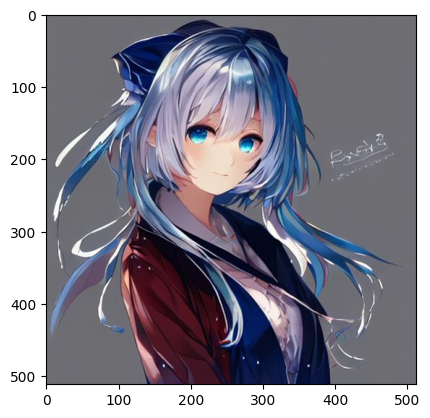